# **Financial Analysis and Trading Strategies (WORK IN PROGRESS)**

## **Contents**
1) [Introduction](#Introduction)
2) [Moving Average Strategy](#Trend-Following)
3) [Bollinger Bands Strategy](#Bollinger-Bands)
4) [Fibonacci Retracement Strategy](#Fibonacci-Retracement)
5) [Credits](#Credits)

## **Introduction**
The purpose of this project is to implement the trading signals of some basic trading startegies using Python. The `numpy`, `scipy`, `pandas`, `matplotlib`, `seaborn`, `warnings`, `riskfolio`, `pypfopt` and `yfinance` libraries are imported for use. Moreover, the plot styles are set for aesthetic reasons and some warnings are ignored (as they are concerned with unused features in this project at the time of conception).

In [23]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wrn
import riskfolio as rsk
import pypfopt as ppf
import yfinance as yf

palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_style(style = "whitegrid", rc = {"font.family":"Times New Roman", "font.weight":"bold"})
wrn.filterwarnings(action = "ignore")

## **Moving Average Strategy**
The moving average strategy is a simple strategy that involves generating trading signals based on the evolution of two moving averages, each with a different lookback period: one representing a short-term trend in an asset price, and another representing a long-term trend in said asset price. For instance, the following trading signals can be generated (although others can also be applied instead):
 - If the short-term moving average of an asset's price exceeds its long-term moving average, take a long position in the asset. Close the position once this no longer holds true, and;
 - If the short-term moving average of an asset's price is exceeded by its long-term moving average, take a short position in the asset. Close the position once this no longer holds true.

The Python implementation for the above trading strategy is given in the following example in the code cell below:

Expected Return: 0.19% (47.02%, if annualised)
Volatility: 2.73% (43.36%, if annualised)
Sharpe Ratio: 0.07 (1.08 if annaualised)
Total cumulative return: 45.63%
Maximum drawdown: -43.34 units of local currency


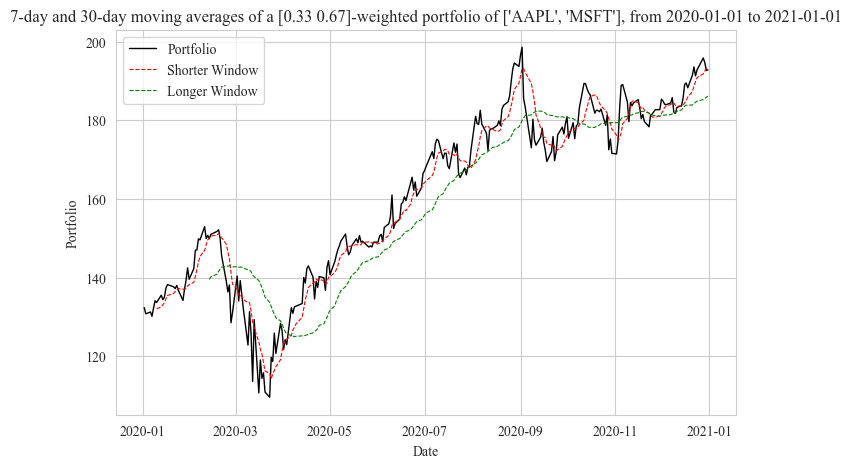

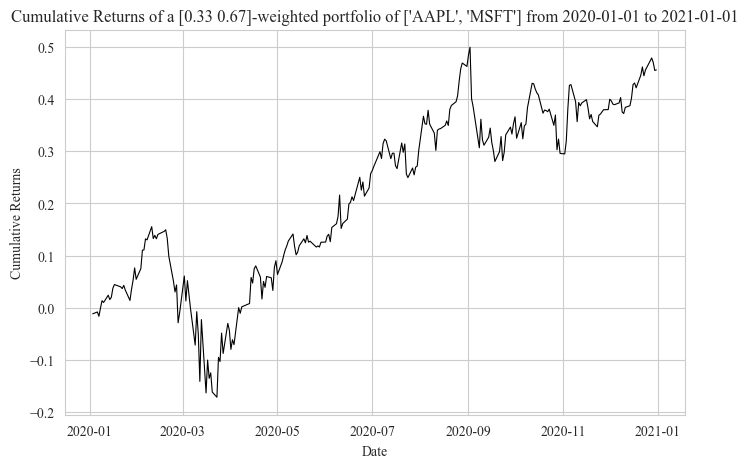

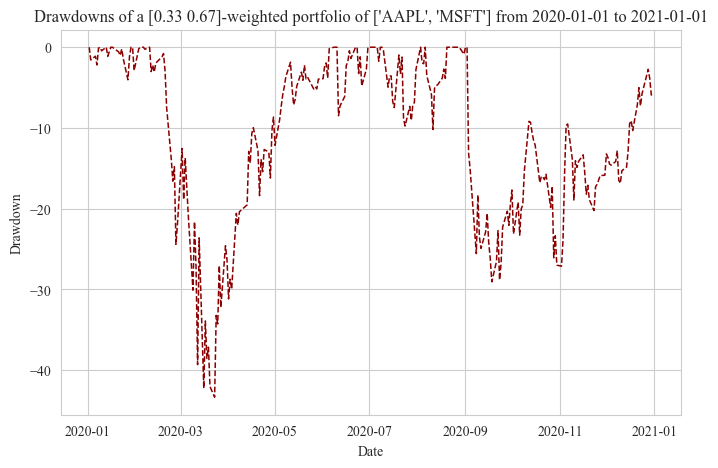

In [24]:
def moving_average_strategy(tickers, start_date, end_date, weights, window_1 = 7, window_2 = 30, show_performance_metrics = False, show_visualisations = False):
    """
    Generates the trading signals of a moving average trading strategy on a portfolio for a pair of lookback windows.
    
    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    weights : list/np.ndarray
        An array or list of asset weights for the portfolio
    window_1 : int, optional
        An integer denoting one of the lookback windows, which must strictly greater than one and distinct from the other lookback window. Default : 7
    window_2 : int, optional
        An integer denoting one of the lookback windows, which must strictly greater than one and distinct from the other lookback window. Default : 14
    show_performance_metrics : bool, optional
        A flag determining whether or not to show the performance metrics of the strategy. Default : False
    show_visualizations : bool, optional
        A flag determining whether or not to show the visualization of the risk measure. Default : False

    Returns
    -------
    pandas.core.frame.DataFrame
        A pandas DataFrame object containing the portfolio's price data, its key metrics and its trading signals, in addition to the closing price data of the individual assets therein.
    """
    assert all(isinstance(d, t) for d, t in zip([tickers, start_date, end_date, weights, window_1, window_2], [list, str, str, list, int, int])), "At least one argument has the wrong data type. Please check the function docstring for more guidance."
    assert all(isinstance(ticker, str) for ticker in tickers), "At least one ticker element is of the wrong data type. Please ensure all tickers are in string format."
    assert sum(weights) == 1, "The portfolio must be capital budgeted. Please ensure that the weights sum up to 1."
    assert dt.datetime.strptime(start_date, "%Y-%m-%d") < dt.datetime.strptime(end_date, "%Y-%m-%d"), "The start date must strictly precede the end date"
    assert 1 < min(window_1, window_2) and window_1 != window_2, "The lookback windows must be strictly greater than one and cannot coincide."
    shorter_window, longer_window = min(window_1, window_2), max(window_1, window_2)
    df = yf.download(tickers, start_date, end_date, progress = False)["Close"]
    weights = np.round(weights, 2)
    if len(tickers) == 1:
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        })
    else:
        df["Portfolio"] = np.dot(weights, df.T)
    df["Shorter Window"] = df["Portfolio"].rolling(shorter_window).mean()
    df["Longer Window"] = df["Portfolio"].rolling(longer_window).mean()
    df["Returns"] = df["Portfolio"].pct_change()
    df["Cumulative Returns"] = df["Returns"].add(1).cumprod().sub(1)
    df["Drawdown"] =  df["Portfolio"] - df["Portfolio"].cummax()
    df["Trading Signals"] = 0
    df.loc[df["Shorter Window"] > df["Longer Window"], "Trading Signals"] = 1
    df.loc[df["Shorter Window"] < df["Longer Window"], "Trading Signals"] = -1
    if show_performance_metrics:
        expected_return = df["Returns"].mean()
        volatility = df["Returns"].std()
        sharpe_ratio = expected_return / volatility
        total_cumulative_return = df["Cumulative Returns"].values[-1]
        maximum_drawdown = df["Drawdown"].min()
        print(f"Expected Return: {expected_return:.2%} ({252 * expected_return:.2%}, if annualised)")
        print(f"Volatility: {volatility:.2%} ({np.sqrt(252) * volatility:.2%}, if annualised)")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f} ({np.sqrt(252) * sharpe_ratio:.2f} if annaualised)")
        print(f"Total cumulative return: {total_cumulative_return:.2%}")
        print(f"Maximum drawdown: {maximum_drawdown:.2f} units of local currency")
    else:
        pass
    if show_visualisations:
        plt.figure(figsize=(8, 5), dpi = 100)
        for b, c, w, s in zip(["Portfolio", "Shorter Window", "Longer Window"], ["black", "red", "green"], [1, 0.8, 0.8], ["-", "--", "--"]):
            sns.lineplot(data = df, x = "Date", y = b, color = c, linewidth = w, linestyle = s, label = b)
        plt.legend()
        plt.title(f"{shorter_window}-day and {longer_window}-day moving averages of a {weights}-weighted portfolio of {tickers}, from {start_date} to {end_date}")
        plt.figure(figsize=(8, 5), dpi = 100)
        sns.lineplot(data = df, x = "Date", y = "Cumulative Returns", color = "black", linewidth = 0.8, linestyle = "-")
        plt.title(f"Cumulative Returns of a {weights}-weighted portfolio of {tickers} from {start_date} to {end_date}")
        plt.figure(figsize=(8, 5), dpi = 100)
        sns.lineplot(data = df, x = "Date", y = "Drawdown", linewidth = 1.1, linestyle = "--", color = "darkred")
        plt.title(f"Drawdowns of a {weights}-weighted portfolio of {tickers} from {start_date} to {end_date}")
    else:
        pass
    return df

t = moving_average_strategy(["AAPL", "MSFT"], "2020-01-01", "2021-01-01", [1/3, 2/3], 7, 30, show_performance_metrics = True, show_visualisations = True)

The function's return value can be displayed in the code cell below:

In [25]:
t

Ticker,AAPL,MSFT,Portfolio,Shorter Window,Longer Window,Returns,Cumulative Returns,Drawdown,Trading Signals
Date,,,,,,,,,
2020-01-02,75.087502,160.619995,132.394272,NaN,NaN,NaN,NaN,0.000000,0
2020-01-03,74.357498,158.619995,130.813371,NaN,NaN,-0.011941,-0.011941,-1.580901,0
2020-01-06,74.949997,159.029999,131.283598,NaN,NaN,0.003595,-0.008389,-1.110674,0
2020-01-07,74.597504,157.580002,130.195777,NaN,NaN,-0.008286,-0.016606,-2.198495,0
2020-01-08,75.797501,160.089996,132.273473,NaN,NaN,0.015958,-0.000912,-0.120799,0
...,...,...,...,...,...,...,...,...,...
2020-12-24,131.970001,222.750000,192.792600,190.847800,184.849930,0.007801,0.456200,-5.774893,1
2020-12-28,136.690002,224.960007,195.830905,191.810087,185.254823,0.015759,0.479149,-2.736589,1
2020-12-29,134.869995,224.149994,194.687594,192.553686,185.597160,-0.005838,0.470514,-3.879900,1


## **Bollinger Bands Strategy**
The Bollinger bands strategy is a trading strategy based on the Bollinger bands of an asset's price over a specified lookback window. The three Bollinger bands of an asset's price are the following:
- The middle band: This is the moving average of the asset's price over the specified lookback window.
- The upper band: This is the middle band, plus twice the moving standard deviation of the asset's price over the specified lookback window.
- The lower band: This is the middle band, minus twice the moving standard deviation of the asset's price over the specified lookback window.

The choice of factor of the moving standard deviation in the definition of the upper and lower Bollinger bands need not always be a factor of two. However, this is the general convention, inspired by the normal distribution and, more specifically, the following theorem from probability theory:
$$\forall (\mu, \sigma^2) \in \mathbb{R} \times \mathbb{R}_{+}^{*}, \enspace X \hookrightarrow \mathsf{Normal}(\mu, \sigma^2) \implies \mathbf{P}\left(\left\{\mu - 2 \sigma \leqslant X \leqslant \mu + 2\sigma\right\}\right) \approx 95\%$$
In other words, the convention of multiplying the moving standard deviation of the asset's price by two is a heuristic choice, whereby the at most 5% of the price data falls outside of the Bollinger bands. This is not invariably true, however, because this choice assumes that the asset's price somehow follows a normal distribution, which need not always be the case. 

The following trading signals can be generated (although others can also be applied instead):
- If an asset's price exceeds the upper Bollinger band, take a short position in the asset's price. Close the position when the assets price falls halfway between the upper band and the middle band.;
- If an asset's price is exceeded by the lower Bollinger band, take a long position in the asset's price. Close the position when the assets price rises halfway between the lower band and the middle band.

The Python implementation for the above trading strategy is given in the following example in the code cell below:

Expected Return: 0.27% (67.88%, if annualised)
Volatility: 2.94% (46.71%, if annualised)
Sharpe Ratio: 0.09 (1.45 if annaualised)
Total cumulative return: 76.71%
Maximum drawdown: -27.34 units of local currency


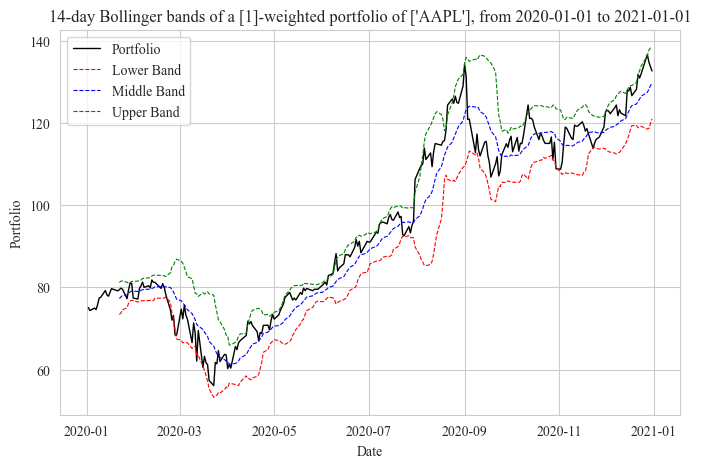

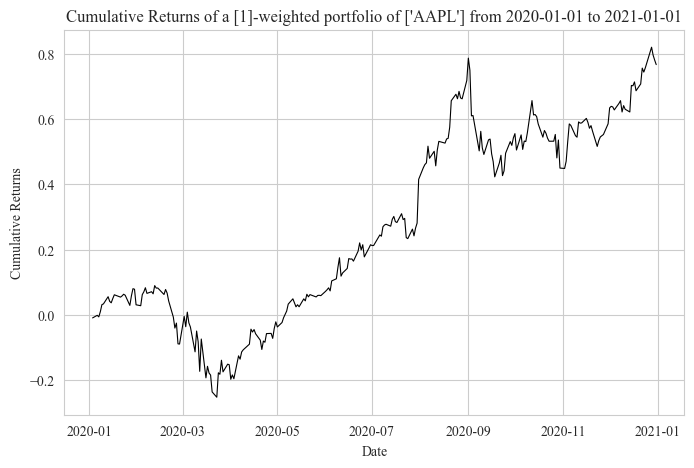

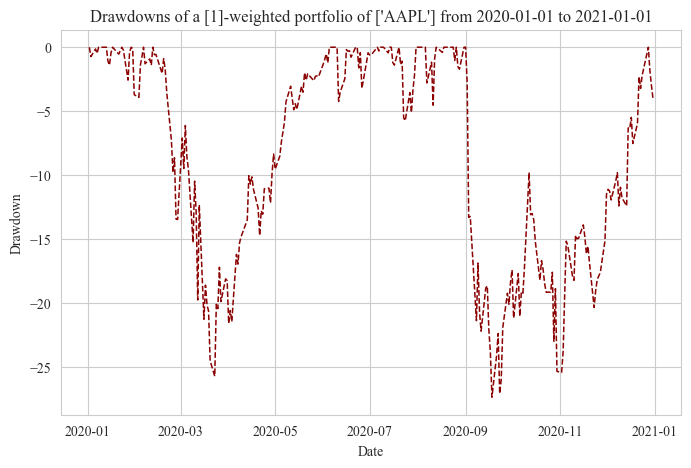

In [26]:
def bollinger_bands_strategy(tickers, start_date, end_date, weights, window = 7, show_performance_metrics = False, show_visualisations = False):
    """
    Generates the trading signals of a Bollinger Bands trading strategy on a portfolio for a lookback window.
    
    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    weights : list/np.ndarray
        An array or list of asset weights for the portfolio
    window : int, optional
        An integer denoting the lookback window. Default : 7
    show_performance_metrics : bool, optional
        A flag determining whether or not to show the performance metrics of the strategy. Default : False
    show_visualizations : bool, optional
        A flag determining whether or not to show the visualization of the risk measure. Default : False

    Returns
    -------
    pandas.core.frame.DataFrame
        A pandas DataFrame object containing the portfolio's price data, its key metrics and the trading signals, in addition to the closing price data of the individual assets therein.
    """
    assert all(isinstance(d, t) for d, t in zip([tickers, start_date, end_date, weights, window], [list, str, str, list, int])), "At least one argument has the wrong data type. Please check the function docstring for more guidance."
    assert all(isinstance(ticker, str) for ticker in tickers), "At least one ticker element is of the wrong data type. Please ensure all tickers are in string format."
    assert sum(weights) == 1, "The portfolio must be capital budgeted. Please ensure that the weights sum up to 1."
    assert dt.datetime.strptime(start_date, "%Y-%m-%d") < dt.datetime.strptime(end_date, "%Y-%m-%d"), "The start date must strictly precede the end date"
    assert 1 < window, "The lookback window must be strictly greater than one."
    df = yf.download(tickers, start_date, end_date, progress = False)["Close"]
    if len(tickers) == 1:
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        })
    else:
        df["Portfolio"] = np.dot(weights, df.T)
    df["Middle Band"] = df["Portfolio"].rolling(window).mean()
    df["Lower Band"] = df["Middle Band"] - 2 * df["Portfolio"].rolling(window).std()
    df["Upper Band"] = df["Middle Band"] + 2 * df["Portfolio"].rolling(window).std()
    df["Returns"] = df["Portfolio"].pct_change()
    df["Cumulative Returns"] = df["Returns"].add(1).cumprod().sub(1)
    df["Drawdown"] =  df["Portfolio"] - df["Portfolio"].cummax()
    df["Trading Signals"] = 0
    df.loc[df["Portfolio"] > df["Upper Band"], "Trading Signals"] = -1
    df.loc[(df["Lower Band"] < 2 * df["Portfolio"] - df["Middle Band"]) & (df["Upper Band"] > 2 * df["Portfolio"] - df["Middle Band"]), "Trading Signals"] = 0
    df.loc[df["Portfolio"] < df["Lower Band"], "Trading Signals"] = 1
    if show_performance_metrics:
        expected_return = df["Returns"].mean()
        volatility = df["Returns"].std()
        sharpe_ratio = expected_return / volatility
        total_cumulative_return = df["Cumulative Returns"].values[-1]
        maximum_drawdown = df["Drawdown"].min()
        print(f"Expected Return: {expected_return:.2%} ({252 * expected_return:.2%}, if annualised)")
        print(f"Volatility: {volatility:.2%} ({np.sqrt(252) * volatility:.2%}, if annualised)")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f} ({np.sqrt(252) * sharpe_ratio:.2f} if annaualised)")
        print(f"Total cumulative return: {total_cumulative_return:.2%}")
        print(f"Maximum drawdown: {maximum_drawdown:.2f} units of local currency")
    else:
        pass
    if show_visualisations:
        plt.figure(figsize=(8, 5), dpi = 100)
        for b, c, w, s in zip(["Portfolio", "Lower Band", "Middle Band", "Upper Band"], ["black", "red", "blue", "green"], [1, 0.8, 0.8, 0.8], ["-", "--", "--", "--"]):
            sns.lineplot(data = df, x = "Date", y = b, color = c, linewidth = w, linestyle = s, label = b)
        plt.legend()
        plt.title(f"{window}-day Bollinger bands of a {weights}-weighted portfolio of {tickers}, from {start_date} to {end_date}")
        plt.figure(figsize=(8, 5), dpi = 100)
        sns.lineplot(data = df, x = "Date", y = "Cumulative Returns", color = "black", linewidth = 0.8, linestyle = "-")
        plt.title(f"Cumulative Returns of a {weights}-weighted portfolio of {tickers} from {start_date} to {end_date}")
        plt.figure(figsize=(8, 5), dpi = 100)
        sns.lineplot(data = df, x = "Date", y = "Drawdown", linewidth = 1.1, linestyle = "--", color = "darkred")
        plt.title(f"Drawdowns of a {weights}-weighted portfolio of {tickers} from {start_date} to {end_date}")
    else:
        pass
    return df

t = bollinger_bands_strategy(["AAPL"], "2020-01-01", "2021-01-01", [1], window = 14, show_performance_metrics = True, show_visualisations = True)

The function's return value can be displayed in the code cell below:

In [27]:
t

,Date,Portfolio,Middle Band,Lower Band,Upper Band,Returns,Cumulative Returns,Drawdown,Trading Signals
0,2020-01-02,75.087502,NaN,NaN,NaN,NaN,NaN,0.000000,0
1,2020-01-03,74.357498,NaN,NaN,NaN,-0.009722,-0.009722,-0.730003,0
2,2020-01-06,74.949997,NaN,NaN,NaN,0.007968,-0.001831,-0.137505,0
3,2020-01-07,74.597504,NaN,NaN,NaN,-0.004703,-0.006526,-0.489998,0
4,2020-01-08,75.797501,NaN,NaN,NaN,0.016086,0.009456,0.000000,0
...,...,...,...,...,...,...,...,...,...
248,2020-12-24,131.970001,126.530714,119.209676,133.851752,0.007712,0.757550,-2.209991,0
249,2020-12-28,136.690002,127.455000,118.550193,136.359808,0.035766,0.820410,0.000000,-1
250,2020-12-29,134.869995,128.204286,118.670908,137.737664,-0.013315,0.796171,-1.820007,0
251,2020-12-30,133.720001,129.057143,119.869430,138.244856,-0.008527,0.780856,-2.970001,0
